<a href="https://colab.research.google.com/github/sleepless-se/Colab/blob/master/page_satus_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt-get -q -y install swig 
!apt-get install mecab
!apt-get install libmecab-dev
!apt-get install mecab-ipadic-utf8
!pip install mecab-python3

Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  swig3.0
Suggested packages:
  swig-doc swig-examples swig3.0-examples swig3.0-doc
The following NEW packages will be installed:
  swig swig3.0
0 upgraded, 2 newly installed, 0 to remove and 10 not upgraded.
Need to get 1,100 kB of archives.
After this operation, 5,822 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 swig3.0 amd64 3.0.12-1 [1,094 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 swig amd64 3.0.12-1 [6,460 B]
Fetched 1,100 kB in 1s (1,146 kB/s)
Selecting previously unselected package swig3.0.
(Reading database ... 131322 files and directories currently installed.)
Preparing to unpack .../swig3.0_3.0.12-1_amd64.deb ...
Unpacking swig3.0 (3.0.12-1) ...
Selecting previously unselected package swig.
Preparing to unpack .../swig_3.0.12-1_amd64.deb ...
Unpacking swig (3.0.12

In [2]:
import sys, pickle, os, json, keras, time, re
from sklearn.model_selection import KFold
from keras.datasets import boston_housing
from keras.models import Model,model_from_json
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,EarlyStopping
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.datasets import mnist
from keras import models
from keras import layers
import numpy as np
from google.colab import files
from keras.metrics import categorical_accuracy
from scipy.stats import zscore
import random
import pandas as pd
import matplotlib.pyplot as plt
import MeCab
mecab = MeCab.Tagger("-Owakati")

Using TensorFlow backend.


In [0]:
def save_text_tokenizer(tokenizer,file_name):
  # saving
  with open(file_name+".pickle", 'wb') as handle:
      pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

def load_text_tokenizer(file_name):
  # loading
  with open(file_name+".pickle", 'rb') as handle:
      return pickle.load(handle)

In [4]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/gdrive')

# After executing the cell above, Drive
# files will be present in "/content/drive/My Drive".
base_dir = "/content/gdrive/My Drive/data/status_filter/"
!ls "/content/gdrive/My Drive/data/status_filter/"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
data  error.csv  page_st.csv  text_token.pickle  weights.best.h5


In [5]:
page_file_name = 'page_st.csv'
target_columns = ['label','text']
dtype ={'label':str,'text':str} 
raw_df = pd.read_csv(base_dir + page_file_name,sep=',',error_bad_lines=False, dtype=dtype,engine='python')
# raw_df2 = pd.read_csv(base_dir + 'new_status.csv',sep=',',error_bad_lines=False, dtype=dtype,engine='python')
# raw_df = pd.concat([raw_df,raw_df2],axis=0)
raw_df = raw_df[~raw_df.duplicated()]
print('raw_df',raw_df.shape)
print(raw_df.columns)
print(raw_df['label'].value_counts())
raw_df.to_csv(base_dir+'page_st.csv',index=False)

raw_df (2233, 3)
Index(['label', 'url', 'text'], dtype='object')
no        1417
stock      536
list       134
top         87
login       24
nan         13
block       11
except      11
Name: label, dtype: int64


In [0]:
def change_label(label):
  if label != 'stock' :label = 'no'
  return label

raw_df['label'] = raw_df['label'].apply(lambda x : change_label(x))

In [7]:
raw_df = raw_df.dropna()
raw_df = raw_df.sample(frac=1)
print(raw_df["label"].value_counts())
print('raw_df',raw_df.shape)
print(raw_df.columns)


no       1697
stock     536
Name: label, dtype: int64
raw_df (2233, 3)
Index(['label', 'url', 'text'], dtype='object')


In [8]:
text = 'sorry we can t this product page 　　re sold out 404 whoops our bad it gone out of stock 切れ 在庫 なし 完売 ました 売り 切れ ページ 見つかり ません この 製品 もう 入手 できません'
def prepro(text:str)->list:
  line = ""
  text = mecab.parse(str(text)).replace("↵"," ")
  text = re.sub('{.*}','',text)
  words = text.lower().split(' ')
  for word in words:
    regex = "^(此|宝|贝|已|下架|품절|또는|판매가|중지된|상품입니다|access|trova|negozio|unfortunate|denied|esaurito|online|only|sorry|we|can|this|product|page|re|sold|404|whoops|ARTICOLO NON DISPONIBILE|our|bad|it|gone|out|of|low|stock|select|no|one|size|please|choose|cat|add|選択|カート|追加|切れ|在庫|なし|し|完売|ました|売り|切れ|ページ|見つかり|ませ|ん|この|製品|もう|入手|でき|ない|ci|scusiamo|per|inconveniente|back|to|our|favs|product|page|item|requested|is|was|not|found|no|longer|server|error|available|購入|いただけ|ません|ARTICLE|EN|LIGNE|so|articolo|non|disponibile|很抱歉|您|查看|的|页面|找不到|了)";
    regex = regex.lower()
    match = re.search(regex, word)
    if match:
      line += word+" "
#   print('line',len(line.split()))
  return line
prepro(text)


'sorry we can this product page re sold out 404 whoops our bad it gone out of stock 切れ 在庫 なし 完売 売り 切れ ページ 見つかり ませ ん この 製品 もう 入手 でき ませ ん '

In [9]:
raw_df['edit_text'] = raw_df['text'].apply(lambda x : prepro(x))
regex = "^(sorry.? (we can.t|this (product|page)))|^(sorry we.re sold out)|^(404|whoops, our bad...|it.s gone|out of stock|sold out|在庫切れ|在庫なし|完売しました|売り切れ|ページが見つかりません.*|この製品はもう入手できない.|ci scusiamo per l'inconveniente.|sorry!|back to our favs)$|(((product|page|item|requested) (is |was )?)(not found|no longer|sold out|out of stock|not available))|(re (sorry|sold out)|(ご購入いただけません)|(404 error))|^(sold out\\s*){3,}|ARTICLE.*EN LIGNE|^so sorry.*|404 page not|Don.t Cry|.*is out of stock.|articolo non disponibile";
p = re.compile(regex)
raw_df['flag'] = raw_df['text'].apply(lambda x : 0 if p.match(x) == None else 1)
raw_df['edit_text'] = raw_df['edit_text'].fillna("")

token = keras.preprocessing.text.Tokenizer(num_words=250)
token.fit_on_texts(raw_df['edit_text'].values)
save_text_tokenizer(token,base_dir + 'text_token')
X = token.texts_to_matrix(raw_df['edit_text'].values)
flag = np.array(raw_df['flag'])
flag = flag.reshape(len(flag),1)
print('flag',flag.shape,'X',X.shape)
X = np.concatenate((flag,X),axis=1)

# X = flag
# text_len = len(X[0])
# print(f'text_len:{text_len} samples:{len(X)}')
print('word_count',len(token.word_counts))
print(token.word_counts)
print(token.word_index)
X = np.array(X)
print('X',X.shape)

flag (2233, 1) X (2233, 250)
word_count 1438
OrderedDict([('404', 348), ('not', 1974), ('found', 695), ('we', 1485), ('one', 427), ('this', 2053), ('page', 1581), ('to', 7716), ('our', 2893), ('returns', 1652), ('size', 2056), ('please', 818), ('access', 190), ('denied', 58), ('tools', 63), ('website', 478), ('result', 37), ('of', 3697), ('is', 1567), ('enabled', 36), ('reference', 76), ('perimeterx', 36), ('outlet', 181), ('tommy', 114), ('outdoors', 8), ('판매가', 17), ('real', 19), ('return', 538), ('online', 457), ('only', 255), ('review', 535), ('total', 40), ('reserved', 707), ('accessories', 701), ('socks', 45), ('sorry', 278), ('available', 754), ('perform', 5), ('welts', 6), ('sole', 79), ('products', 364), ('off', 1532), ('english', 340), ('register', 438), ('item', 541), ('no', 681), ('out', 976), ('stock', 451), ('reviews', 450), ('now', 693), ('red', 216), ('select', 440), ('back', 784), ('recommendations', 25), ('product', 927), ('wash', 115), ('solid', 52), ('regular', 166)

In [0]:
index2word =  {i+1:key for i, key in enumerate(token.word_index)}
# index2word

In [0]:
# label_token = keras.preprocessing.text.Tokenizer()
# label_token.fit_on_texts(raw_df['label'].values)
# y = label_token.texts_to_matrix(raw_df['label'].values)
# label_len = len(label_token.word_counts) + 1

y = to_categorical(raw_df['label'].apply(lambda x : 1 if x == 'stock' else 0))
# print('word_index',label_token.word_index)
# print('label_len',label_len)
# print('y shape',y.shape)

In [0]:
raw_df['true'] = raw_df['label'].apply(lambda x : 1 if x == 'stock' else 0)

In [32]:

def get_model():
  model = keras.models.Sequential()
  model.add(keras.layers.Embedding(1500, 64, input_length= len(X[0])))
  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dropout(0.5))
  model.add(keras.layers.Dense(256,activation='relu'))
  model.add(keras.layers.Dropout(0.5))
  # model.add(keras.layers.Dense(512,activation='relu'))
  # model.add(keras.layers.Dropout(0.5))
  # model.add(keras.layers.Dense(256,activation='relu'))
  # model.add(keras.layers.Dropout(0.5))
  model.add(keras.layers.Dense(2,activation='softmax'))
  model.compile(loss='categorical_crossentropy',optimizer =keras.optimizers.RMSprop(),metrics=['categorical_accuracy'])
  return model

get_model().summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 251, 64)           96000     
_________________________________________________________________
flatten_10 (Flatten)         (None, 16064)             0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 16064)             0         
_________________________________________________________________
dense_19 (Dense)             (None, 256)               4112640   
_________________________________________________________________
dropout_20 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 2)                 514       
Total params: 4,209,154
Trainable params: 4,209,154
Non-trainable params: 0
_________________________________________________________________


In [33]:

EPOCHS = 100
BATCH_SIZE = 32

# stop when score is not improve
early_stopping = EarlyStopping(monitor='val_categorical_accuracy', patience=20)

# save best score
filepath = base_dir+"weights.best.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=0, save_best_only=True, mode='max')

# reduce 
reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.01)
callbacks_list = [checkpoint,early_stopping,reduce]

scores = []
historys = []
kf = KFold(n_splits=4, random_state=None, shuffle=False)
for train_index, test_index in kf.split(X):
  model = get_model()
  history = model.fit(X[train_index], y[train_index], validation_split=0.2,verbose=0,epochs=EPOCHS,batch_size=BATCH_SIZE,callbacks=callbacks_list)
  historys.append(history)
  score = model.evaluate(X[test_index],y[test_index])
  print(score)
  scores.append(score)

load_model = keras.models.load_model(filepath)
score = load_model.evaluate(X[test_index],y[test_index])
print('Test best loss:', score[0])
print('Test best accuracy:', score[1])

559/559 [==============================] - 0s 74us/step
[0.4169435851902356, 0.9105545618239796]
558/558 [==============================] - 0s 76us/step
[0.38933112387905083, 0.9139784946236559]
558/558 [==============================] - 0s 75us/step
[0.4175443417295867, 0.9032258064516129]
558/558 [==============================] - 0s 95us/step
[0.4390864933583899, 0.9229390674594483]
558/558 [==============================] - 0s 828us/step
Test best loss: 0.3896715171020945
Test best accuracy: 0.9193548380687673


In [34]:
print("KFlod")
print("Sample",len(X))
print("Score",pd.DataFrame(scores).mean()[1]*100)
print("Std",pd.DataFrame(scores).std()[1]*100)


KFlod
Sample 2233
Score 91.26744825896742
Std 0.8181965834450731


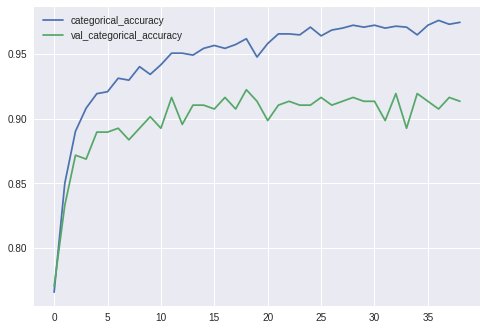

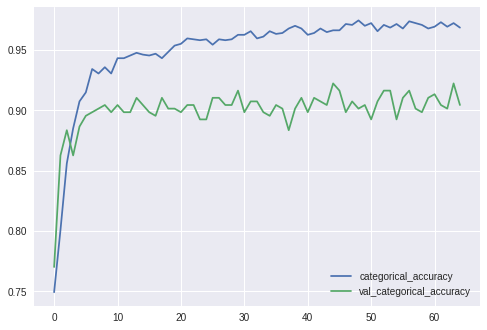

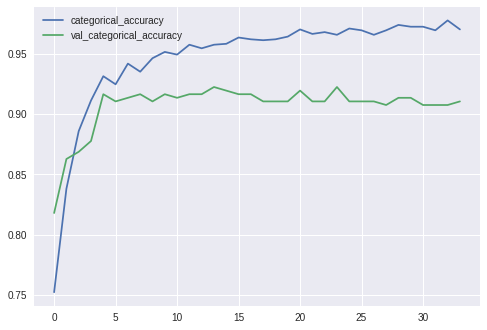

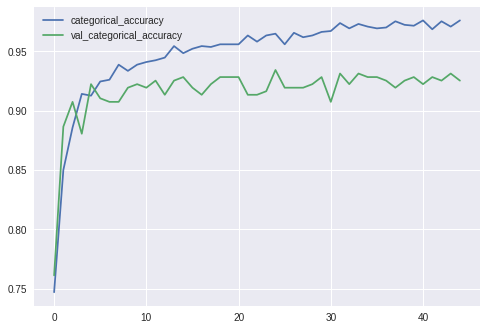

In [35]:
for i in range(len(historys)):
  df = pd.DataFrame(historys[i].history)
#   df.filter(regex=('loss*')).plot()
  df.filter(regex=('accuracy$')).plot()
  
plt.show()
  

dict_keys(['val_loss', 'val_categorical_accuracy', 'loss', 'categorical_accuracy', 'lr'])


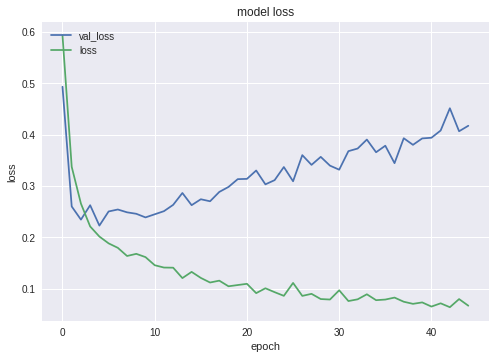

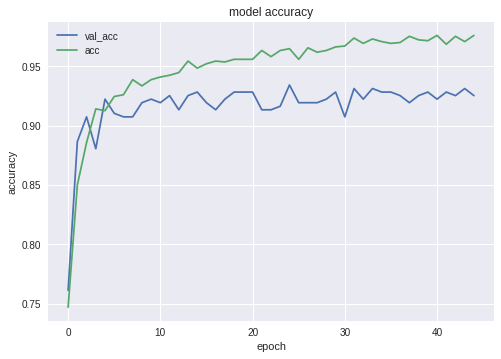

In [36]:

import matplotlib.pyplot as plt

print(history.history.keys())
# summarize history for loss
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['val_loss', 'loss'], loc='upper left')
plt.show()

plt.plot(history.history['val_categorical_accuracy'])
plt.plot(history.history['categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['val_acc', 'acc'], loc='upper left')
plt.show()

In [37]:
len(test_index)

558

In [0]:
raw_df['pred'] = load_model.predict(X).argmax(axis=1)

In [39]:
error_df = raw_df.query("true != pred")
print(len(error_df))
error_df[['label','true','pred','edit_text','url']].to_csv(base_dir+'error.csv',index=False)

103
